 ### Importação das bibliotecas necessárias

In [1]:
import pyspark

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *

spark = SparkSession.builder.getOrCreate()

In [110]:
import pandas as pd
import requests 
import zipfile
import os
import datetime
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx

from io import BytesIO
from shapely.geometry import Point, Polygon

plt.style.use("seaborn")

import warnings
warnings.filterwarnings('ignore')

### Download dos dados

In [3]:
# cria um diretório para armazenar o conteúdo baixado
os.makedirs('./datasets', exist_ok = True)

In [4]:
# define a url em que os arquivos se encontram
url = "https://casetecnicodatasprints.s3.amazonaws.com/datasets/datasets.zip"

# download do arquivo
filebytes = BytesIO(requests.get(url).content)

# extrai o conteúdo do zipfile
myzip = zipfile.ZipFile(filebytes)
myzip.extractall("./datasets")

### Criação dos DataFrames

#### Dataframe trips

* Spark DataFrame

In [5]:
# leitura dos arquivos json
trips1 = spark.read.json('./datasets/data-sample_data-nyctaxi-trips-2009-json_corrigido.json')
trips2 = spark.read.json('./datasets/data-sample_data-nyctaxi-trips-2010-json_corrigido.json')
trips3 = spark.read.json('./datasets/data-sample_data-nyctaxi-trips-2011-json_corrigido.json')
trips4 = spark.read.json('./datasets/data-sample_data-nyctaxi-trips-2012-json_corrigido.json')

In [6]:
# concatena os dataframes
trips = trips1.unionAll(trips2).unionAll(trips3).unionAll(trips4)

In [7]:
trips.show(3)

+--------------------+----------------+-----------------+-----------+---------------+------------+--------------------+---------------+----------------+---------+------------------+---------+----------+------------+------------+-------------+---------+
|    dropoff_datetime|dropoff_latitude|dropoff_longitude|fare_amount|passenger_count|payment_type|     pickup_datetime|pickup_latitude|pickup_longitude|rate_code|store_and_fwd_flag|surcharge|tip_amount|tolls_amount|total_amount|trip_distance|vendor_id|
+--------------------+----------------+-----------------+-----------+---------------+------------+--------------------+---------------+----------------+---------+------------------+---------+----------+------------+------------+-------------+---------+
|2009-04-21T18:57:...|        40.74795|       -73.994712|        5.4|              2|        Cash|2009-04-21T18:51:...|       40.74295|      -74.004114|     null|              null|      0.0|       0.0|         0.0|         5.4|          0.8

In [8]:
# cria uma view do dataframe
trips.createOrReplaceTempView("trips")

* Pandas DataFrame

In [9]:
# leitura dos arquivos json
trips1 = pd.read_json('./datasets/data-sample_data-nyctaxi-trips-2009-json_corrigido.json', lines = True)
trips2 = pd.read_json('./datasets/data-sample_data-nyctaxi-trips-2010-json_corrigido.json', lines = True)
trips3 = pd.read_json('./datasets/data-sample_data-nyctaxi-trips-2011-json_corrigido.json', lines = True)
trips4 = pd.read_json('./datasets/data-sample_data-nyctaxi-trips-2012-json_corrigido.json', lines = True)

In [10]:
# concatena os dataframes
trips_pd = pd.concat([trips1, trips2, trips3, trips4])

In [11]:
trips_pd.head(3)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,tip_amount,tolls_amount,total_amount
0,CMT,2009-04-21T18:51:11.767205+00:00,2009-04-21T18:57:09.433767+00:00,2,0.80,-74.004114,40.742950,NaN,NaN,-73.994712,40.747950,Cash,5.4,0.0,0.0,0.0,5.4
1,CMT,2009-01-13T07:40:07.639754+00:00,2009-01-13T07:50:36.386011+00:00,1,5.40,-73.996506,40.747784,NaN,NaN,-73.940449,40.792385,Cash,15.4,0.0,0.0,0.0,15.4
2,VTS,2009-01-06T19:30:44.142187+00:00,2009-01-06T19:43:09.908429+00:00,5,1.67,-73.951340,40.752070,NaN,NaN,-73.944535,40.768108,CASH,6.1,1.0,0.0,0.0,7.1


#### DataFrame vendor

* Spark DataFrame

In [12]:
# leitura do arquivo csv
vendor = spark.read.csv("./datasets/data-vendor_lookup-csv.csv", sep = ",", header="true")

In [13]:
vendor.show(3)

+---------+--------------------+--------------------+--------+-----+-----+-------+--------------------+-------+
|vendor_id|                name|             address|    city|state|  zip|country|             contact|current|
+---------+--------------------+--------------------+--------+-----+-----+-------+--------------------+-------+
|      CMT|Creative Mobile T...|950 4th Road Suit...|Brooklyn|   NY|11210|    USA|contactCMT@gmail.com|    Yes|
|      VTS|        VeriFone Inc|       26 Summit St.|Flushing|   NY|11354|    USA|   admin@vtstaxi.com|    Yes|
|      DDS|Dependable Driver...|8554 North Homest...|   Bronx|   NY|10472|    USA|          9778896500|    Yes|
+---------+--------------------+--------------------+--------+-----+-----+-------+--------------------+-------+
only showing top 3 rows



In [14]:
# cria uma view do dataframe
vendor.createOrReplaceTempView("vendor")

* Pandas DataFrame

In [15]:
# leitura do arquivo csv
vendor_pd = pd.read_csv('./datasets/data-vendor_lookup-csv.csv')

In [16]:
vendor_pd.head(3)

,vendor_id,name,address,city,state,zip,country,contact,current
0,CMT,"Creative Mobile Technologies, LLC",950 4th Road Suite 78,Brooklyn,NY,11210,USA,contactCMT@gmail.com,Yes
1,VTS,VeriFone Inc,26 Summit St.,Flushing,NY,11354,USA,admin@vtstaxi.com,Yes
2,DDS,"Dependable Driver Service, Inc",8554 North Homestead St.,Bronx,NY,10472,USA,9778896500,Yes


#### DataFrame payment

* Pandas DataFrame

In [17]:
# leitura do arquivo csv
payment_pd = pd.read_csv('./datasets/data-payment_lookup-csv.csv', skiprows = 1)

In [18]:
payment_pd.head(3)

,payment_type,payment_lookup
0,Cas,Cash
1,CAS,Cash
2,Cre,Credit


## Transformações

#### DataFrame trips

In [32]:
# mesclando dataframes, para que as questões sejam respondidas com maiores detalhes

# adiciona as colunas do dataframe vendor no dataframe trips_pd 
trips_merge = pd.merge(trips_pd, vendor_pd, how = 'left', on = 'vendor_id')

# adiciona as colunas do dataframe payment no dataframe trips_pd
trips_pd = pd.merge(trips_merge, payment_pd, how = 'left', on = 'payment_type')

In [33]:
# converte a coluna dropoff_datetime para o tipo datetime
trips_pd["dropoff_datetime"] = trips_pd["dropoff_datetime"].astype("datetime64")
trips_pd["pickup_datetime"] = trips_pd["pickup_datetime"].astype("datetime64")

# calcula o tempo total da viagem
trips_pd['total_travel_time'] = trips_pd['dropoff_datetime'] - trips_pd['pickup_datetime']

# ***Quesitos mínimos***

## **1. Qual a distância média percorrida por viagens com no máximo 2 passageiros**;

* ### Resolução com Spark SQL

In [20]:
distancia = spark.sql("SELECT AVG(trip_distance) distancia_media FROM trips WHERE passenger_count <= 2")
distancia.show()

+------------------+
|   distancia_media|
+------------------+
|2.6625269962032303|
+------------------+



* ### Resolução com Pandas DataFrame

In [23]:
# cálculo da média
trips_pd.loc[
    (trips_pd.passenger_count <= 2)  
].trip_distance.mean()

2.6625269962030926

## **2. Quais os 3 maiores vendors em quantidade total de dinheiro arrecadado**;

* ### Resolução com Spark SQL

In [25]:
# junta os dataframes trips e vendor
top_vendors = trips.join(vendor, "vendor_id")

In [26]:
# cria uma view do dataframe top_vendors
top_vendors.createOrReplaceTempView("top_vendors")

In [28]:
# seleciona a coluna name da view top_vendors e soma o total de dinheiro arrecadado por cada um 
top_v = spark.sql("""SELECT name, format_number(SUM(total_amount),2) total 
                FROM top_vendors GROUP BY vendor_id, name 
                ORDER BY SUM(total_amount) DESC LIMIT 3""")
top_v.show(truncate = False)

+---------------------------------+-------------+
|name                             |total        |
+---------------------------------+-------------+
|Creative Mobile Technologies, LLC|19,549,084.28|
|VeriFone Inc                     |19,043,434.00|
|Dependable Driver Service, Inc   |2,714,901.72 |
+---------------------------------+-------------+



* ### Resolução com Pandas DataFrame

In [34]:
# mostra apenas duas casas decimais
pd.set_option('display.float_format', '{:.2f}'.format)

# calcula o total arrecadado por cada vendor e mostra em um dataframe
top_vendors_pd = trips_pd.groupby('name')['total_amount'].sum().reset_index()
top_vendors_pd.sort_values(by='total_amount')[3:0:-1].reset_index(drop=True)

,name,total_amount
0,"Creative Mobile Technologies, LLC",19549084.28
1,VeriFone Inc,19043434.00
2,"Dependable Driver Service, Inc",2714901.72


## **3. Faça um histograma da distribuição mensal, nos 4 anos, de corridas pagas em dinheiro**;

* ### Resolução com Pandas DataFrame

In [35]:
# cria uma cópia das colunas selecionadas do dataframe trips_pd
trips_cash = trips_pd[['dropoff_datetime','payment_lookup']].copy()

In [36]:
# seleciona apenas as viagens pagas em dinheiro
trips_cash = trips_cash.loc[trips_cash["payment_lookup"] == "Cash"]

In [37]:
# reseta o index do dataframe
trips_cash.reset_index(inplace=True, drop=True)

In [38]:
# Cria novas colunas para ano e mês
trips_cash['year'] = trips_cash['dropoff_datetime'].dt.year
trips_cash['month'] = trips_cash['dropoff_datetime'].dt.month
trips_cash = trips_cash.drop('dropoff_datetime', axis = 1)

In [39]:
# conta quantas corridas foram pagas em dinheiro por dia e cria uma nova coluna
trips_cash['total'] = trips_cash.groupby(['year','month'])['payment_lookup'].transform('count')

In [40]:
# remove linhas duplicadas
trips_cash = trips_cash.drop_duplicates()

In [41]:
trips_cash.reset_index(inplace=True, drop=True)

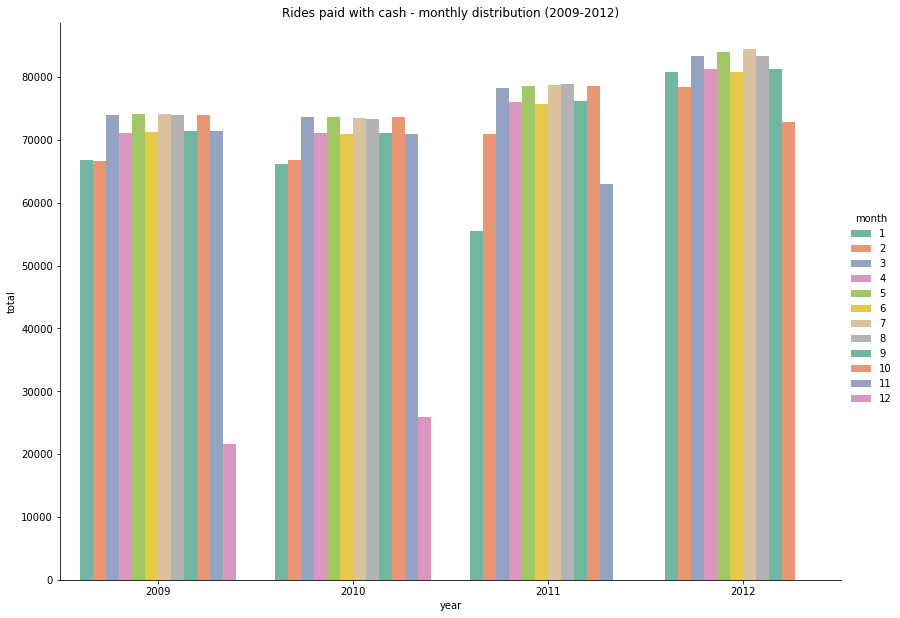

In [42]:
# constrói o gráfico
sns.color_palette("tab10")
sns.catplot(x="year", y="total", hue="month", kind="bar", data=trips_cash,\
           height=8.27, aspect=11.7/8.27, palette="Set2")\
.set(title='Rides paid with cash - monthly distribution (2009-2012)');

## **4. Faça um gráfico de série temporal contando a quantidade de gorjetas de cada dia, nos últimos 3 meses de 2012.**

* ### Resolução com Pandas DataFrame

In [79]:
# cria uma cópia das colunas dropoff_datetime e tip_amount do dataframe trips_pd
trips_tips = trips_pd[['dropoff_datetime','tip_amount']].copy()

In [80]:
# filtra as linhas dos 3 últimos meses de 2012 em que houveram gorjetas
trips_tips = trips_tips.loc[
    (trips_tips['dropoff_datetime'].dt.year == 2012) &
    (trips_tips['dropoff_datetime'].dt.month >= 10) &
    (trips_tips['tip_amount'] > 0)]

In [81]:
trips_tips.reset_index(inplace=True, drop=True)

In [82]:
# Cria novas colunas para ano e mês
trips_tips['month'] = trips_tips['dropoff_datetime'].dt.month
trips_tips['day'] = trips_tips['dropoff_datetime'].dt.day
trips_tips = trips_tips.drop('dropoff_datetime', axis=1)

In [83]:
# conta a quantidade de gorjetas por dia, agrupadas por mês
trips_tips['total'] = trips_tips.groupby(['month','day'])['tip_amount'].transform('count')

In [84]:
trips_tips = trips_tips.drop('tip_amount', axis=1)
trips_tips = trips_tips.drop_duplicates()

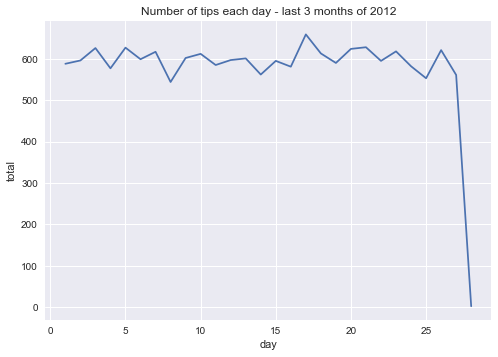

In [85]:
# constrói o gráfico
sns.lineplot(x='day', y='total', data = trips_tips)\
.set(title='Number of tips each day - last 3 months of 2012');

# ***Quesitos bônus***

## **● Qual o tempo médio das corridas nos dias de sábado e domingo;**

* ### Resolução com Pandas DataFrame

In [87]:
# seleciona apenas os dias de sábado e domingo e calcula a média do tempo de duração das corridas
avg_time = trips_pd.loc[
    (trips_pd['dropoff_datetime'].dt.day_name() == 'Saturday') |
    (trips_pd['dropoff_datetime'].dt.day_name() == 'Sunday')
].total_travel_time.mean()

In [91]:
print('O tempo médio das corridas nos dias de sábado e domingo é de', avg_time)

o tempo médio das corridas nos dias de sábado e domingo é de 0 days 00:08:44.787484850


## **● Fazer uma visualização em mapa com latitude e longitude de pickups and dropoffs no ano de 2010;**

* ### Pickups map

In [101]:
# CRS -> Coordinate Reference Systems, para a visualização dos dados no mapa
crs = {'init':'epsg:4326'}

In [93]:
geodf = trips_pd[['dropoff_datetime','pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].copy()

In [94]:
# remove as linhas que não são do ano de 2010
geodf = geodf.drop(geodf[geodf['dropoff_datetime'].dt.year != 2010].index)

In [95]:
geodf.reset_index(inplace=True, drop=True)

In [98]:
# cria pontos a partir da longitude e latitude e adiciona na coluna geometry 
geometry = [Point(xy) for xy in zip(geodf['pickup_longitude'], geodf['pickup_latitude'])]
geometry[:3]

In [106]:
geo_df = gpd.GeoDataFrame(geodf, crs = crs, geometry = geometry)

In [107]:
geo1 = geo_df[['geometry','dropoff_datetime']].copy()

In [108]:
pickup_map = geo1.to_crs(epsg=3857)

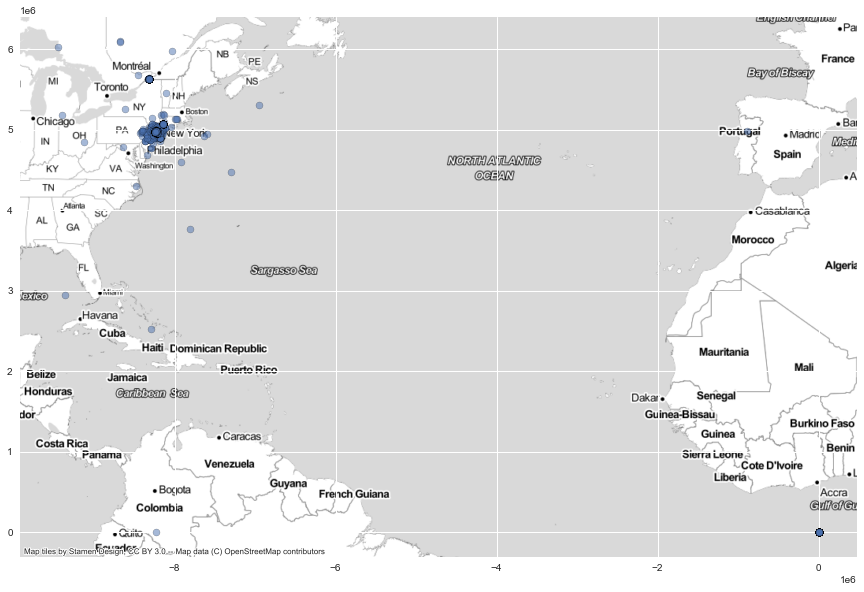

In [146]:
# visualização dos pontos no mapa
ax = pickup_map.plot(figsize=(15, 15), alpha=0.5, edgecolor='k')
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)

* ### Dropoffs map

In [133]:
geodf2 = trips_pd[['dropoff_datetime','pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].copy()

In [134]:
# remove as linhas que não são do ano de 2010
geodf2 = geodf.drop(geodf[geodf['dropoff_datetime'].dt.year != 2010].index)

In [135]:
geodf2.reset_index(inplace=True, drop=True)

In [136]:
# cria pontos a partir da longitude e latitude e adiciona na coluna geometry 
geometry = [Point(xy) for xy in zip(geodf2['dropoff_longitude'], geodf2['dropoff_latitude'])]
geometry[:3]

In [137]:
geo_df2 = gpd.GeoDataFrame(geodf2, crs = crs, geometry = geometry)

In [139]:
geo2 = geo_df2[['geometry','dropoff_datetime']].copy()

In [140]:
dropoff_map = geo2.to_crs(epsg=3857)

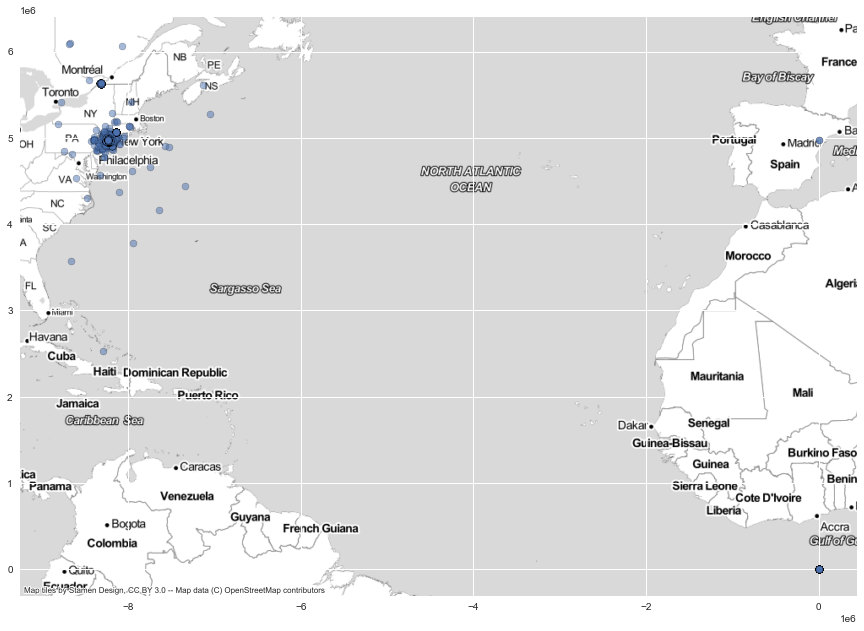

In [141]:
# visualização dos pontos no mapa
ax = dropoff_map.plot(figsize=(15, 15), alpha=0.5, edgecolor='k')
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)